In [1]:
import numpy
import torch
from numba import jit, guvectorize
from src import State, StateList
from src.utils import plot_trajectory

In [2]:
@guvectorize(['void(f4[:,:], f4[:,:], f4[:], f4[:], f4, f4[:])',
              'void(f8[:,:], f8[:,:], f8[:], f8[:], f8, f8[:])'], 
             '(b, d), (b, d), (), (b), () -> ()', nopython=True)
def n_body_hamiltonian(q, p, t, m, G, res):
    res[0] = 0
    for body in range(q.shape[0]):
        for dim in range(q.shape[1]):
            res[0] += 0.5 * p[body, dim]**2 / m[body]
        for body2 in range(q.shape[0]):
            if body == body2:
                continue
            r2 = 0
            for dim in range(q.shape[1]):
                r2 += (q[body, dim] - q[body2, dim])**2
            res[0] -= 0.5 * G * m[body] * m[body2] / r2**0.5

In [3]:
@jit(nopython=True)
def n_body_trajectory(q, p, t, m, G, dt):
    for index in range(1, q.shape[0]):
        for body in range(q.shape[1]):
            for dim in range(q.shape[2]):
                dq_dt = p[index - 1, body, dim] / m[body]
                dp_dt = 0
                for body2 in range(q.shape[1]):
                    if body == body2:
                        continue
                    r2 = 0
                    for dim2 in range(q.shape[2]):
                        r2 += (q[index - 1, body, dim2] - q[index - 1, body2, dim2])**2
                    F = G * m[body] * m[body2] / r2
                    projection = (q[index - 1, body2, dim] - q[index - 1, body, dim]) / r2**0.5
                    dp_dt += F * projection 
                q[index, body, dim] = q[index - 1, body, dim] + dq_dt * dt
                p[index, body, dim] = p[index - 1, body, dim] + dp_dt * dt
        t[index] = t[index - 1] + dt

In [4]:
def calculate_hamiltonian(state, m, G):
    energies = n_body_hamiltonian(state.q.detach().numpy(), state.p.detach().numpy(),
                                  state.t.numpy(), m.numpy(), G.item())
    return torch.from_numpy(energies)

In [5]:
def calculate_trajectory(initial_state, m, G, num_steps, time_step):
    q = torch.empty((num_steps, *initial_state.shape), dtype=initial_state.dtype)
    p = torch.empty((num_steps, *initial_state.shape), dtype=initial_state.dtype)
    t = torch.empty(num_steps, dtype=initial_state.dtype)
    trajectory = StateList(q, p, t)
    trajectory[0] = initial_state
    n_body_trajectory(q.detach().numpy(), p.detach().numpy(), t.numpy(), 
                      m.numpy(), G.item(), time_step)
    return trajectory

In [6]:
PI = 3.14159265358979323
SOLAR_MASS = 4 * PI * PI
DAYS_PER_YEAR = 365.24
dtype = torch.float64
m = torch.tensor([1.0000e+00, # Sun
                  9.5479e-04, # Jupiter
                  2.8588e-04, # Saturn
                  4.3662e-05, # Uranus
                  5.1513e-05, # Neptune
                 ], dtype=dtype) * SOLAR_MASS
G = torch.tensor(1.0, dtype=dtype)
time_step = 1e-5
num_steps = int(5e7)
initial_state = State(q=torch.tensor([[0.0, 0.0, 0.0], # Sun
                                      [+4.8414e+00, -1.1603e+00, -1.0362e-01], # Jupiter
                                      [+8.3433e+00, +4.1247e+00, -4.0352e-01], # Saturn
                                      [+1.2894e+01, -1.5111e+01, -2.2330e-01], # Uranus
                                      [+1.5379e+01, -2.5919e+01, +1.7925e-01]],# Neptune
                                     dtype=dtype),
                      p=torch.tensor([[0.0, 0.0, 0.0], # Sun
                                      [+1.6600e-03, +7.6990e-03, -6.9046e-05], # Jupiter
                                      [-2.7674e-03, +4.9985e-03, +2.3041e-05], # Saturn
                                      [2.96460e-03, +2.3784e-03, -2.9658e-05], # Uranus
                                      [2.68067e-03, +1.6282e-03, -9.5159e-05]],# Neptune
                                     dtype=dtype) * DAYS_PER_YEAR * m.unsqueeze(1).expand(-1, 3),
                      t=torch.tensor(0.0, dtype=dtype))

In [7]:
%%time
trajectory = calculate_trajectory(initial_state,m, G, num_steps, time_step)

CPU times: user 24.9 s, sys: 2.67 s, total: 27.6 s
Wall time: 27.6 s


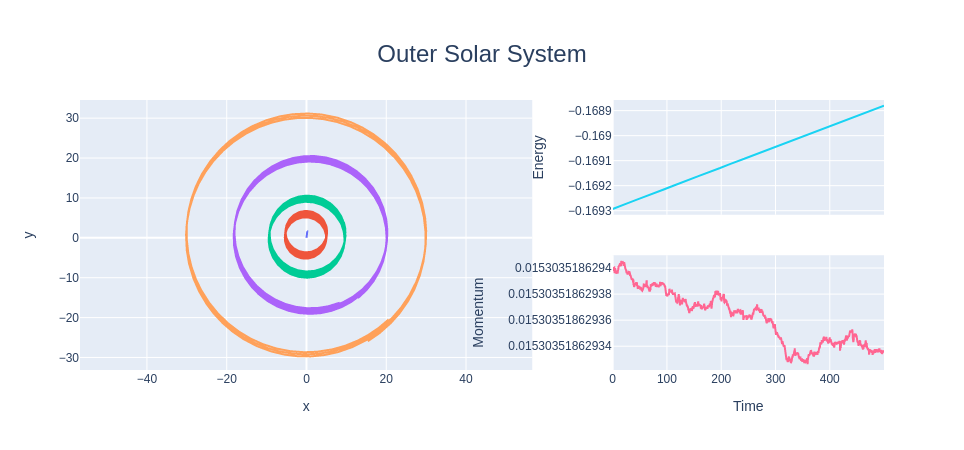

In [8]:
fig = plot_trajectory(trajectory, calculate_hamiltonian, m=m, G=G, 
                      name='Outer Solar System', skip=10000)
fig.show()